In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("GPU not available. Please check runtime settings.")

✅ GPU is available: NVIDIA GeForce RTX 4060


In [74]:
# !pip install transformers

Import necessary library

In [75]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [76]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import data

In [77]:
df = pd.read_csv("dataset\Sentiment Analysis for Mental Health.csv")
df = df.sample(frac=0.1, random_state=42)
df.shape

(5304, 3)

EDA and cleaning data

In [78]:
# Let's have a look at the data
df.head()

,Unnamed: 0,statement,status
22261,22261,Just as the the title says. I feel like one is...,Depression
41400,41400,a blackened sky encroached tugging behind it m...,Depression
20065,20065,"It gives you insomnia, which in turn makes you...",Depression
30036,30036,"Hello all, I'm a new submitter to this channel...",Normal
780,780,Thank God the CB is over for Eid,Normal


In [79]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 5304 entries, 22261 to 23011
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5304 non-null   int64 
 1   statement   5263 non-null   object
 2   status      5304 non-null   object
dtypes: int64(1), object(2)
memory usage: 165.8+ KB


,Unnamed: 0
count,5304.000000
mean,26680.773379
std,15323.596857
min,4.000000
25%,13505.750000
50%,27083.500000
75%,39859.250000
max,53022.000000


In [80]:
# Let's check for missing values
df.isnull().sum()

Unnamed: 0     0
statement     41
status         0
dtype: int64

In [81]:
df[df.isna().any(axis=1)]

,Unnamed: 0,statement,status
50354,50354,NaN,Bipolar
51209,51209,NaN,Personality disorder
52637,52637,NaN,Anxiety
51220,51220,NaN,Personality disorder
50571,50571,NaN,Bipolar
52627,52627,NaN,Anxiety
50022,50022,NaN,Bipolar
49384,49384,NaN,Stress
48460,48460,NaN,Stress
50768,50768,NaN,Personality disorder


In [82]:
df = df.dropna()
df.info()
df.describe()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 5263 entries, 22261 to 23011
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5263 non-null   int64 
 1   statement   5263 non-null   object
 2   status      5263 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.5+ KB


(5263, 3)

In [83]:
# Let's check for missing values again
df.isnull().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [84]:
df['status'].value_counts()

status
Normal                  1648
Depression              1603
Suicidal                 952
Anxiety                  377
Stress                   289
Bipolar                  278
Personality disorder     116
Name: count, dtype: int64

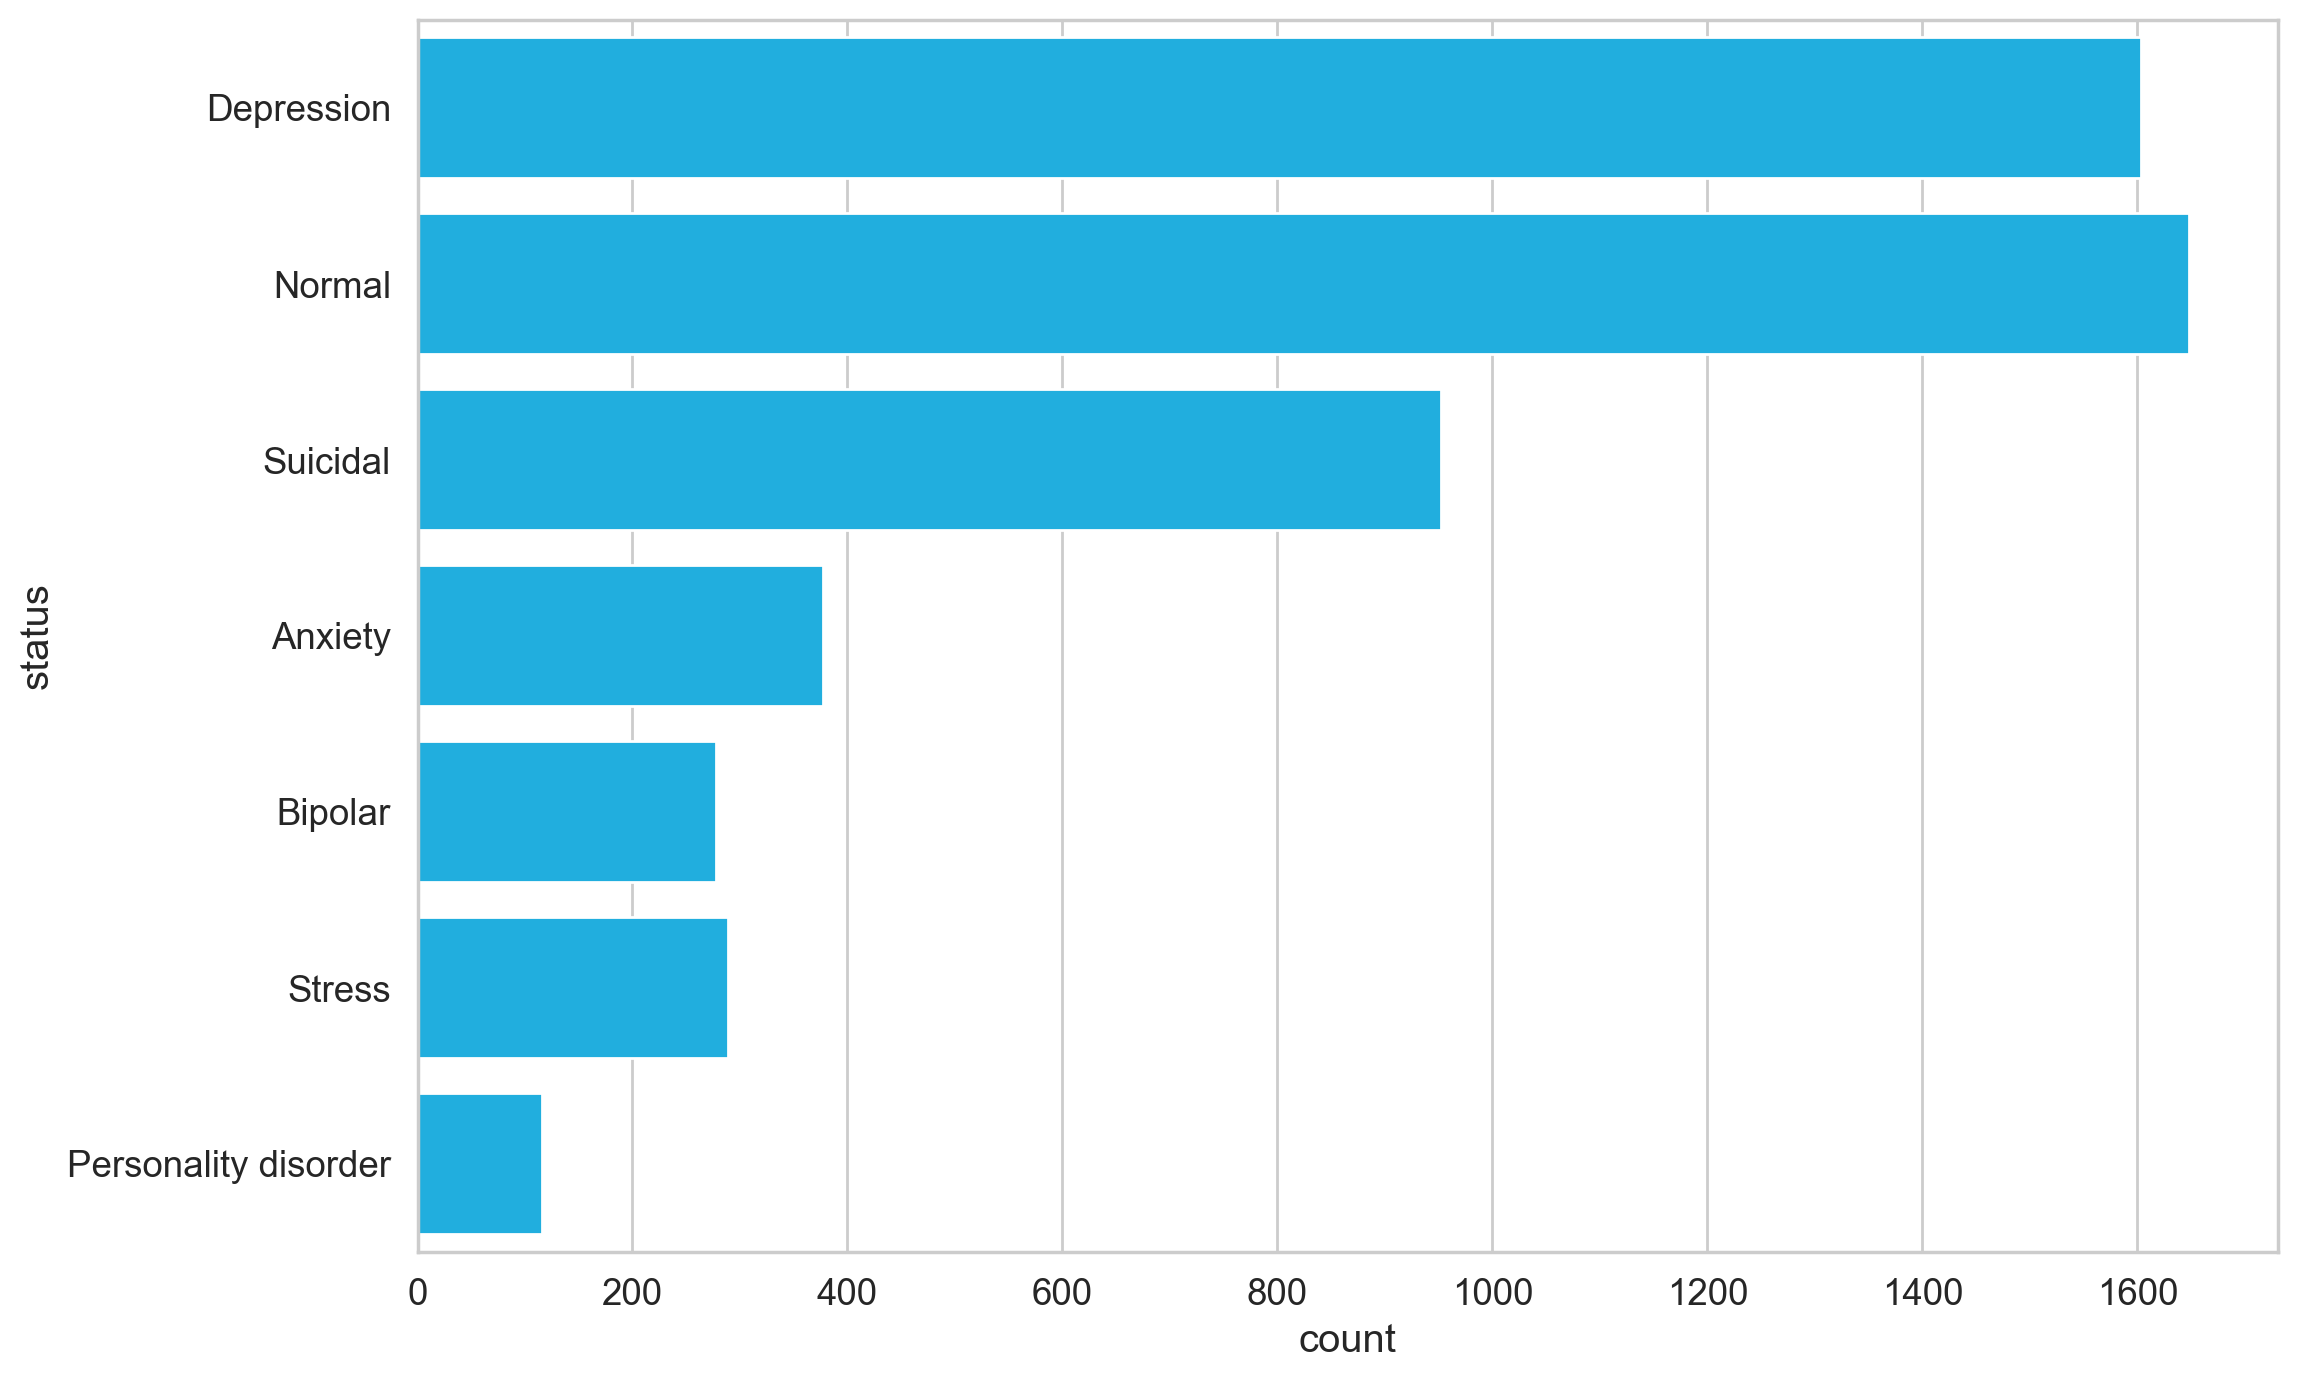

In [85]:
# Let's have a look at the class balance.
sns.countplot(df.status)
plt.xlabel('count');

Data preprocessing

In [86]:
possible_label = df.status.unique()
dict_label = {}
for index,possible_label in enumerate(possible_label):
    dict_label[possible_label] = index
dict_label

{'Depression': 0,
 'Normal': 1,
 'Suicidal': 2,
 'Anxiety': 3,
 'Bipolar': 4,
 'Stress': 5,
 'Personality disorder': 6}

In [87]:
df["Label"] = df["status"].replace(dict_label)
df.head()

,Unnamed: 0,statement,status,Label
22261,22261,Just as the the title says. I feel like one is...,Depression,0
41400,41400,a blackened sky encroached tugging behind it m...,Depression,0
20065,20065,"It gives you insomnia, which in turn makes you...",Depression,0
30036,30036,"Hello all, I'm a new submitter to this channel...",Normal,1
780,780,Thank God the CB is over for Eid,Normal,1


In [ ]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# train 80%, test 20%
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, stratify=df["Label"])

# split test 20% to val/test = val 10%, test 10%
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test["Label"])

df_train["data_type"] = "train"
df_val["data_type"] = "val"
df_test["data_type"] = "test"

df = pd.concat([df_train, df_val, df_test])


In [89]:
df.head()

,Unnamed: 0,statement,status,Label,data_type
28622,28622,"I know he's never going to be the same, but it...",Stress,5,train
42206,42206,ikimb0 i just seen ur tweet plz write bak if u...,Normal,1,train
40429,40429,i wish i could just be normal and happy i have...,Depression,0,train
52869,52869,Doctors notes/records Hi just wondering if any...,Anxiety,3,train
36028,36028,ooo apple store is down ... so close? Credit c...,Normal,1,train


In [90]:
df.groupby(['status','Label','data_type']).count()

Unnamed: 0  statement
status               Label data_type                       
Anxiety              3     test               38         38
                           train             302        302
                           val                37         37
Bipolar              4     test               28         28
                           train             222        222
                           val                28         28
Depression           0     test              161        161
                           train            1282       1282
                           val               160        160
Normal               1     test              165        165
                           train            1318       1318
                           val               165        165
Personality disorder 6     test               11         11
                           train              93         93
                           val                12         12
Stress               5     test               29         29
                           train             231        231
                           val                29         29
Suicidal             2     test               95         95
                           train             762        762
                           val                95         95

In [91]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [92]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

In [93]:
encoder_train = tokenizer.batch_encode_plus(
    df[df["data_type"] == 'train'].statement.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',           
    truncation=True,
    max_length=300,
    return_tensors='pt'
)

encoder_test = tokenizer.batch_encode_plus(
    df[df["data_type"] == 'test'].statement.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=300,
    return_tensors='pt'
)

encoder_val = tokenizer.batch_encode_plus(
    df[df["data_type"] == 'val'].statement.values.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    max_length=300,
    return_tensors='pt'
)


input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train['attention_mask']
labels_train = torch.tensor(df[df['data_type'] == 'train'].Label.values)

input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test['attention_mask']
labels_test = torch.tensor(df[df['data_type'] == 'test'].Label.values)

input_ids_val = encoder_val['input_ids']
attention_masks_val = encoder_val["attention_mask"]
labels_val = torch.tensor(df[df['data_type']=='val'].Label.values)

In [94]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)
data_val = TensorDataset(input_ids_val,attention_masks_val,labels_val)

In [95]:
len(data_train),len(data_test),len(data_val)

(4210, 527, 526)

Create function

In [96]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = len(dict_label),
                                     output_attentions = False,
                                     output_hidden_states =  False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# TensorDatasets
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

# DataLoaders
BATCH_SIZE = 16

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=BATCH_SIZE)
dataloader_val = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=BATCH_SIZE)
dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=BATCH_SIZE)

In [98]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)

epochs  = 10
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs
)

In [99]:
from sklearn.metrics import accuracy_score

def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [100]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

Loading:cuda


In [126]:
from tqdm import tqdm
def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions,true_vals = [],[]

    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)


    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [123]:
def get_accuracy_from_dataloader(dataloader):
    model.eval()
    predictions, true_vals = [], []
    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return accuracy_score(np.argmax(predictions, axis=1), true_vals)


Loss train-validate for store model best performance state

In [121]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None

In [ ]:
from tqdm import tqdm
import pandas as pd

history = []

for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc=f"Epoch {epoch}", leave=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[2]
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

    # === Summary this epoch ===
    loss_train_avg = loss_train_total / len(dataloader_train)
    train_losses.append(loss_train_avg)

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_acc = accuracy_score_func(predictions, true_vals)
    train_acc = get_accuracy_from_dataloader(dataloader_train)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    tqdm.write(f"\nEpoch {epoch}")
    tqdm.write(f"Training Loss: {loss_train_avg:.4f} |Train Accuracy: {train_acc:.4f}")
    tqdm.write(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    

    history.append({
    'epoch': epoch,
    'train_loss': loss_train_avg,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc
    })

    # === Save best model ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        tqdm.write(f"✅ Saved best model at epoch {epoch} (Val Acc: {val_acc:.4f})")

# save result to CSV
df_history = pd.DataFrame(history)
df_history.to_csv(r"results\training_results.csv", index=False)
print("✅ Saved training results to training_results.csv")

 10%|█         | 1/10 [09:09<1:22:23, 549.24s/it]


Epoch 1
Training Loss: 1.2289 |Train Accuracy: 0.6601
Val Loss: 0.9311 | Val Accuracy: 0.6331
✅ Saved best model at epoch 1 (Val Acc: 0.6331)


 20%|██        | 2/10 [18:17<1:13:08, 548.59s/it]


Epoch 2
Training Loss: 0.7911 |Train Accuracy: 0.7684
Val Loss: 0.7251 | Val Accuracy: 0.7395
✅ Saved best model at epoch 2 (Val Acc: 0.7395)


 30%|███       | 3/10 [27:25<1:03:58, 548.35s/it]


Epoch 3
Training Loss: 0.5978 |Train Accuracy: 0.8240
Val Loss: 0.6356 | Val Accuracy: 0.7624
✅ Saved best model at epoch 3 (Val Acc: 0.7624)


 40%|████      | 4/10 [36:33<54:49, 548.26s/it]  


Epoch 4
Training Loss: 0.4670 |Train Accuracy: 0.8423
Val Loss: 0.5993 | Val Accuracy: 0.7700
✅ Saved best model at epoch 4 (Val Acc: 0.7700)


 50%|█████     | 5/10 [45:41<45:41, 548.23s/it]


Epoch 5
Training Loss: 0.3701 |Train Accuracy: 0.9154
Val Loss: 0.5620 | Val Accuracy: 0.7985
✅ Saved best model at epoch 5 (Val Acc: 0.7985)


 60%|██████    | 6/10 [54:49<36:32, 548.15s/it]


Epoch 6
Training Loss: 0.2876 |Train Accuracy: 0.9468
Val Loss: 0.5464 | Val Accuracy: 0.8042
✅ Saved best model at epoch 6 (Val Acc: 0.8042)


 70%|███████   | 7/10 [1:03:57<27:24, 548.12s/it]


Epoch 7
Training Loss: 0.2290 |Train Accuracy: 0.9435
Val Loss: 0.5976 | Val Accuracy: 0.7947


 80%|████████  | 8/10 [1:13:05<18:16, 548.08s/it]


Epoch 8
Training Loss: 0.1770 |Train Accuracy: 0.9615
Val Loss: 0.6278 | Val Accuracy: 0.7928


 90%|█████████ | 9/10 [1:22:13<09:08, 548.04s/it]


Epoch 9
Training Loss: 0.1466 |Train Accuracy: 0.9765
Val Loss: 0.6346 | Val Accuracy: 0.8061
✅ Saved best model at epoch 9 (Val Acc: 0.8061)


100%|██████████| 10/10 [1:31:21<00:00, 548.17s/it]


Epoch 10
Training Loss: 0.1239 |Train Accuracy: 0.9751
Val Loss: 0.6523 | Val Accuracy: 0.7928
✅ Saved training results to training_results.csv


In [ ]:
model.save_pretrained('bert_finetuned')
tokenizer.save_pretrained('bert_finetuned')

('bert_finetuned_new\\tokenizer_config.json',
 'bert_finetuned_new\\special_tokens_map.json',
 'bert_finetuned_new\\vocab.txt',
 'bert_finetuned_new\\added_tokens.json')

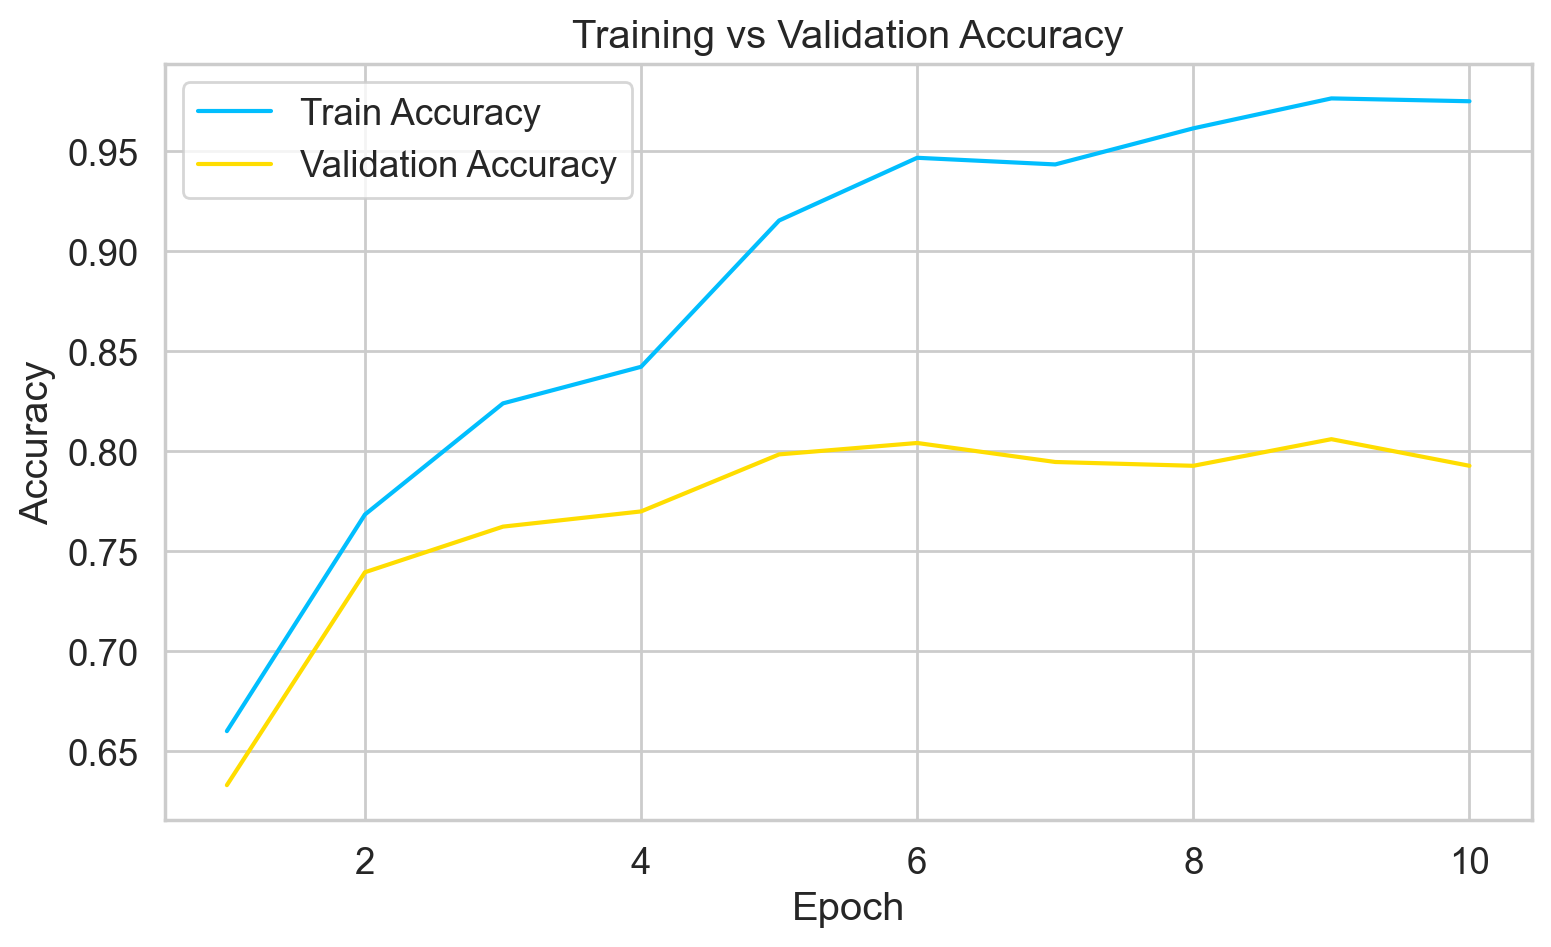

In [110]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results\accuracy_plot.png", dpi=300, bbox_inches='tight')
plt.show()

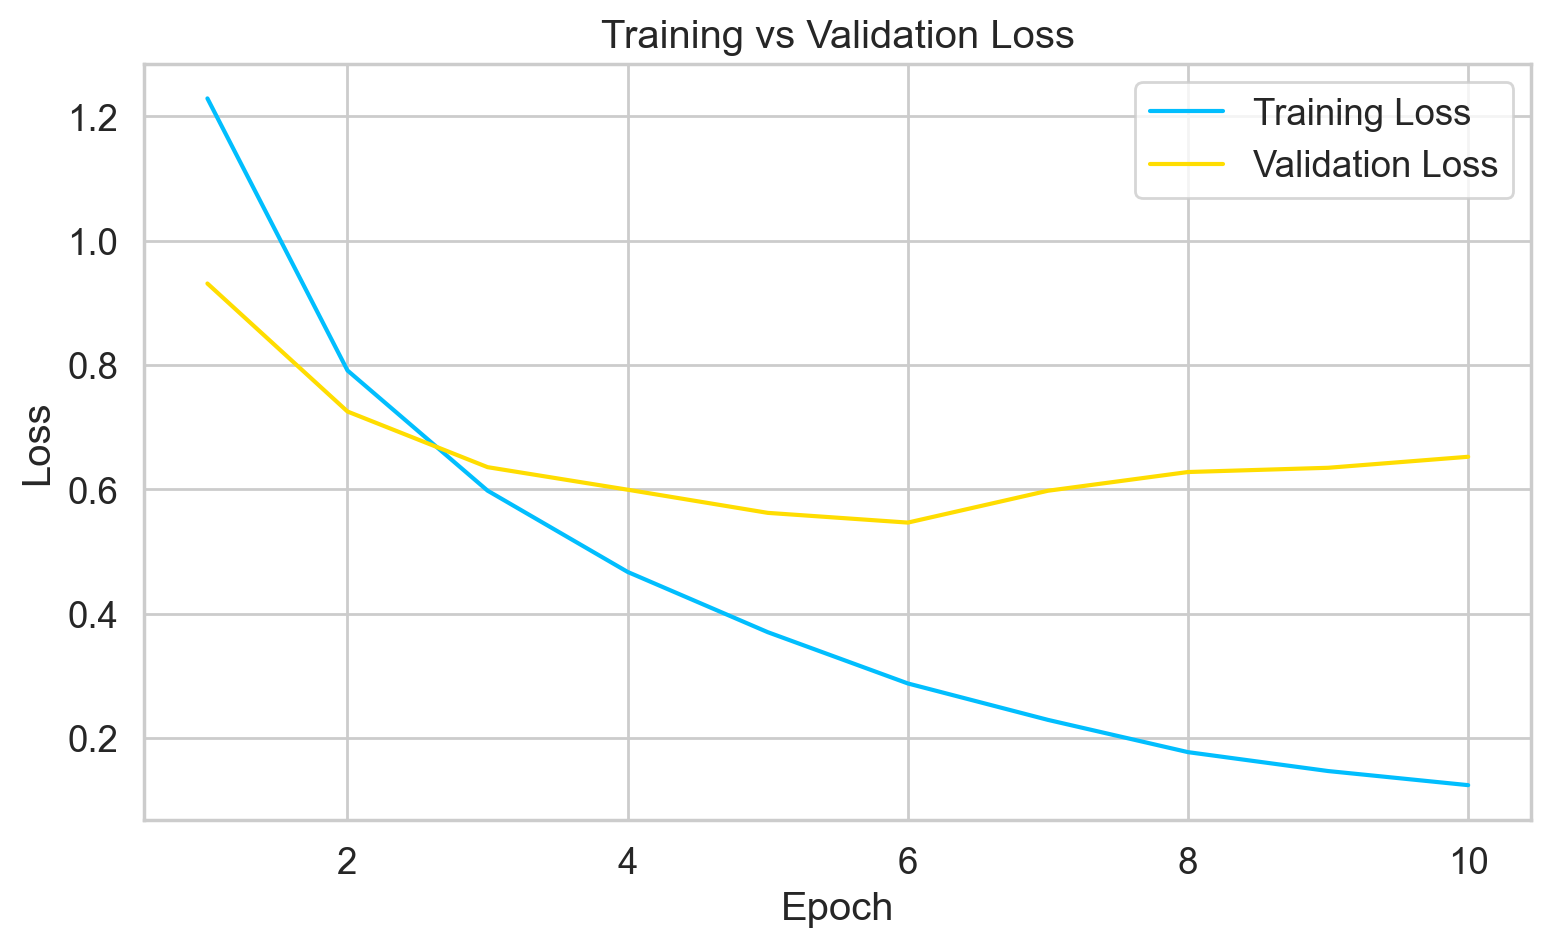

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"results\loss_plot.png", dpi=300, bbox_inches='tight')
plt.show()


Evaluation

In [118]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("bert_finetuned")
tokenizer = AutoTokenizer.from_pretrained("bert_finetuned")

In [119]:
from sklearn.metrics import classification_report

def get_classification_report(preds, labels, label_names=None):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    report = classification_report(labels_flat, preds_flat, target_names=label_names)
    return report

In [131]:
# load best model
model.load_state_dict(best_model_state)
model.eval()

# evaluate
test_loss, predictions, true_vals = evaluate(dataloader_test)

# label names
label_names = ['Depression', 'Normal', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']

# print report
report = get_classification_report(predictions, true_vals, label_names=label_names)
print("Classification Report:\n")
print(report)

TypeError: Expected state_dict to be dict-like, got <class 'NoneType'>.

In [129]:
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(true_vals, 
                                    np.argmax(predictions, axis=1), 
                                    target_names=label_names, 
                                    output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_latex("results\BERT_classification_report.tex", float_format="%.2f")


NameError: name 'label_names' is not defined